#### Raquel Senior 

## Homework 2 

# Instructions 

1) Visualize brain tumor images that demonstrate when images have tumors and when they do not have tumors.

2) Discuss why building a predictive model using this data might be practically useful.  Who could benefit from a model like this? Explain.

3) Run at least three prediction models to try to predict brain tumor MRI images well.

4) Use transfer learning for at least one of these models

5) Discuss which models performed better and point out relevant hyper-parameter values for successful models.

6) Submit your best model to the leader board for the Brain Tumor Diagnostic AI Model Share competition.

7) Import the best model from the leader board (whatever the best model is after your final submission)
Note: Import the model's config and it's optimization config.

8) Visualize the model's structure using tf.kera's model.summary() 

9) Explain how the model's structure is different from your best model.

#### Submission: https://github.com/raquel904/ML_projects

In [0]:
import sys
import time
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import zipfile

from skimage.transform import resize
from sklearn.model_selection import train_test_split


from tensorflow.python.keras.utils import np_utils
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.python.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D 
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.python.keras.applications import vgg19, resnet, inception_v3


In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [5]:
base_path = '/content/gdrive/My Drive/Colab Notebooks/brain_tumor_dataset'
categories = ['no', 'yes']

# load file names to fnames list object
fnames = []
for category in categories:
    brain_tumor_folder = os.path.join(base_path, category)
    file_names = os.listdir(brain_tumor_folder)
    full_path = [os.path.join(brain_tumor_folder, file_name) for file_name in file_names]
    fnames.append(full_path)

print('number of images for each category:', [len(f) for f in fnames])
print(fnames[0:4]) #examples of file names

number of images for each category: [98, 155]
[['/content/gdrive/My Drive/Colab Notebooks/brain_tumor_dataset/no/30 no.jpg', '/content/gdrive/My Drive/Colab Notebooks/brain_tumor_dataset/no/no.jpg', '/content/gdrive/My Drive/Colab Notebooks/brain_tumor_dataset/no/14 no.jpg', '/content/gdrive/My Drive/Colab Notebooks/brain_tumor_dataset/no/18 no.jpg', '/content/gdrive/My Drive/Colab Notebooks/brain_tumor_dataset/no/no 9.png', '/content/gdrive/My Drive/Colab Notebooks/brain_tumor_dataset/no/no 10.jpg', '/content/gdrive/My Drive/Colab Notebooks/brain_tumor_dataset/no/41 no.jpg', '/content/gdrive/My Drive/Colab Notebooks/brain_tumor_dataset/no/22 no.jpg', '/content/gdrive/My Drive/Colab Notebooks/brain_tumor_dataset/no/3 no.jpg', '/content/gdrive/My Drive/Colab Notebooks/brain_tumor_dataset/no/no 8.jpg', '/content/gdrive/My Drive/Colab Notebooks/brain_tumor_dataset/no/no 7.jpeg', '/content/gdrive/My Drive/Colab Notebooks/brain_tumor_dataset/no/43 no.jpg', '/content/gdrive/My Drive/Colab No

In [0]:
from keras.preprocessing import image
import numpy as np
from PIL import Image

def load_image(img_path):
        img = Image.open(img_path).convert("RGB").resize((224,224)) # import image, make sure it's RGB and resize to height and width you want.
        img = (np.float32(img)-np.float32(img).min())/(np.float32(img).max()-np.float32(img).min()) # min max transformation
        img=img.reshape((224,224,3)) # Create final shape as array with correct dimensions for Keras
        return img

# read in all images from filenames

preprocessed_image_data=list(map(load_image, fnames[0]+fnames[1])) 

X= np.array(preprocessed_image_data)

In [7]:
print(len(preprocessed_image_data) ) #same number of elements as filenames
print(preprocessed_image_data[0].shape ) #dimensions now 192,192,3 for all images
print(preprocessed_image_data[0].min() ) #min value of every image is zero
print(preprocessed_image_data[0].max() ) #max value of every image is one
X.shape 

253
(224, 224, 3)
0.0
1.0


(253, 224, 224, 3)

In [8]:
from itertools import repeat

no=list(repeat("no",98)) 
yes=list(repeat("yes",155))

y_labels = no+yes

import pandas as pd
y= pd.get_dummies(y_labels)
len(y) 
display(y)

,no,yes
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0
...,...,...
248,0,1
249,0,1
250,0,1
251,0,1


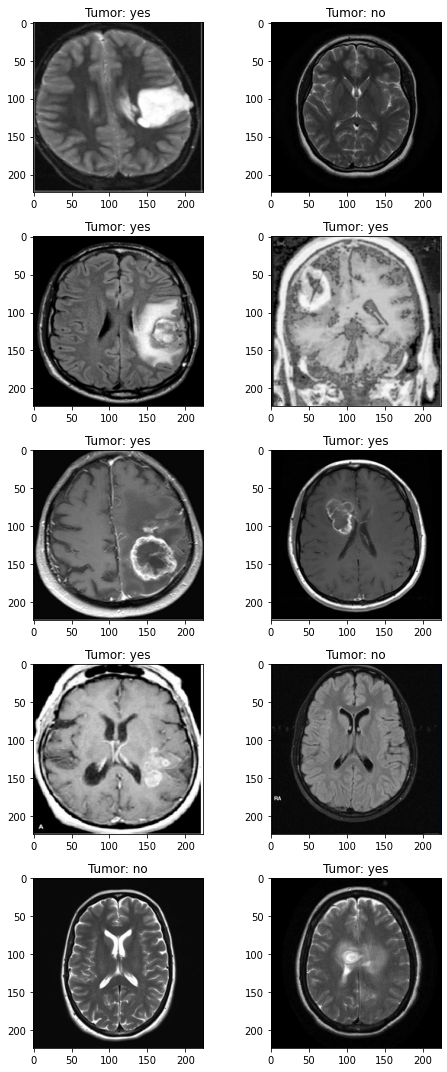

In [9]:
#1
fig,ax=plt.subplots(5,2)
fig.set_size_inches(7,15)
for i in range(5):
    for j in range (2):
        l= np.random.randint(0,len(y_labels))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Tumor: '+y_labels[l])
        
plt.tight_layout()

2) Building a predictive model using brain tumor IMR images is usefull for health care providers and their patients; because the model would enable the latter to identify tumors faster, which in turn enables patients to start treatment promptly and have a higher chance of being cured

In [10]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20,random_state=42) # y is the preprocessed data 


y_train 

,no,yes
38,1,0
143,0,1
84,1,0
55,1,0
217,0,1
...,...,...
106,0,1
14,1,0
92,1,0
179,0,1


Model 1 has three convolutional layers with 64 filters each. All convolutional layers were activated with relu. The output layer was built to classify two categories, tumor and no tumor. 5 epochs were used. Further, stochastic gradient descent, with a learning rate of 0.001 was used as an optimization technique.

In [11]:
#3
# Model 1 

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout,BatchNormalization,Flatten
from tensorflow.keras.optimizers import SGD
with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.
      opt=SGD(lr=.001)

      model = Sequential()
      model.add(Dense(64,  input_shape=(224, 224, 3), activation='relu'))
      model.add(Dense(64, activation='relu'))
      model.add(Dense(64, activation='relu'))
      model.add(Flatten())
      model.add(Dense(2, activation='softmax')) 
                                                  
      # Compile model
      model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

      # Fitting the NN to the Training set
      model.fit(X_train, y_train, 
                    epochs = 5, verbose=1,validation_data=(X_test,y_test))

Epoch 1/5
7/7 [==============================] - 19s 3s/step - loss: 0.6377 - accuracy: 0.6139 - val_loss: 0.6074 - val_accuracy: 0.6078
Epoch 2/5
7/7 [==============================] - 18s 3s/step - loss: 0.5987 - accuracy: 0.6238 - val_loss: 0.5875 - val_accuracy: 0.7255
Epoch 3/5
7/7 [==============================] - 18s 3s/step - loss: 0.5949 - accuracy: 0.6683 - val_loss: 0.5807 - val_accuracy: 0.8235
Epoch 4/5
7/7 [==============================] - 18s 3s/step - loss: 0.5666 - accuracy: 0.7376 - val_loss: 0.5515 - val_accuracy: 0.8039
Epoch 5/5
7/7 [==============================] - 18s 3s/step - loss: 0.5600 - accuracy: 0.7772 - val_loss: 0.5492 - val_accuracy: 0.8431


Model 2 has ten convolutional layers. Eight of which have 32 filters with a kernel size of either 3 or 1. The layer, right before the outer layer has a filter of 8. And the layer right above it has a filter of 16. All convolutional layers were activated using Relu. 

Like model 1, model 2 has 5 epochs. However, when the value accuracy failed to improved after 3 epochs the learning rate was divided by 10. So, this model uses Adam optimiser to reach to the global minima while training.

For the above reasons, model 2 has a higher accuracy than model 1 


In [12]:
# Model 2 
with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model = tf.keras.Sequential([
    # input: images of size 192x192x3 pixels (the three stands for RGB channels)    
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu', input_shape=[224, 224, 3]),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=16, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=8, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    # classifying into 2 categories
    tf.keras.layers.Dense(2, activation='softmax')
  ])
  from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1) # dividing lr by 10 when val_accuracy fails to improve after 3 epochs

  model.compile(
    optimizer="adam",
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
  
  # Fitting the CNN to the Training set
  model.fit(X_train, y_train, 
                    epochs = 5, verbose=1,validation_data=(X_test,y_test))

Epoch 1/5
7/7 [==============================] - 14s 2s/step - loss: 0.6679 - accuracy: 0.5842 - val_loss: 0.6300 - val_accuracy: 0.6078
Epoch 2/5
7/7 [==============================] - 14s 2s/step - loss: 0.6280 - accuracy: 0.6238 - val_loss: 0.6038 - val_accuracy: 0.6863
Epoch 3/5
7/7 [==============================] - 14s 2s/step - loss: 0.5327 - accuracy: 0.6832 - val_loss: 0.4804 - val_accuracy: 0.8039
Epoch 4/5
7/7 [==============================] - 14s 2s/step - loss: 0.5492 - accuracy: 0.7178 - val_loss: 0.4889 - val_accuracy: 0.7647
Epoch 5/5
7/7 [==============================] - 14s 2s/step - loss: 0.5383 - accuracy: 0.7525 - val_loss: 0.4707 - val_accuracy: 0.8039


5) Model 3 is my most accurate model; because of its use of transfer learning (adaptation of a prebuilt model to the tumor data), Adam optimization, and increase in the number of epochs. 

This model was created by importing a prebuilt model code from the Imagenet competition and then adding a new structure to the first layer and the final layers to conform to the tumor data. It has:

- 2 convolution layers of 64 channel of 3x3 kernel and same padding
- 1 maxpool layer of 2x2 pool size and stride 2x2
- 2 convolution layers of 128 channel of 3x3 kernel and same padding
- 1 maxpool layer of 2x2 pool size and stride 2x2
- 4 convolution layers of 256 channel of 3x3 kernel and same padding
- 1 maxpool layer of 2x2 pool size and stride 2x2
- 3 convolution layers of 512 channel of 3x3 kernal and same padding
- 1 maxpool layer of 2x2 pool size and stride 2x2
- 5 convolution layers of 512 channel of 3x3 kernal and same padding
- 1 maxpool layer of 2x2 pool size and stride 2x2
In this model after the data passes through all the convolution layers; it passes through the dense layer so that the vector is flattened. This vector comes out of the convolutions and adds:

- 1 Dense layer of 4096 units
- 1 Dense layer of 4096 units
- 1 Dense Softmax layer of 2 units. Each unit represents a binary outcome: brain tumor or no brain tumor.

The model has 19 layers and about 140 million of trainable parameters.

The convolutional layers are activated through a linear function, Relu. But, the last layer uses softmax activation, which is more appropriate for classification problems.

It uses Adam optimiser to reach to the global minima while training.

In [13]:
#4
# Model 3

from tensorflow.keras.applications import VGG19

base_model = VGG19(input_shape=(224,224,3),
                                               include_top=False, # Drops fully connected layers and output layer structure from pretrained model.
                                               weights='imagenet') # Using weight from model trained to 1000 categories of imagenet competition
base_model.summary()

80142336/80134624 [==============================] - 0s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [14]:
from tensorflow.keras.applications import VGG19
# load model
model = VGG19()

# summarize the model
model.summary()

574717952/574710816 [==============================] - 4s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [15]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras import backend as K


# load model new input layer shape.

IMG_SHAPE = (224, 224, 3)

# Create the base model from the pre-trained model VGG19
base_model = VGG19(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

base_model.summary()


Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [16]:
base_model.trainable = False

base_model.summary() 

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [17]:
model = Sequential([
  base_model,
   GlobalAveragePooling2D(),
   Dense(2,activation="softmax")
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 7, 7, 512)         20024384  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 1026      
Total params: 20,025,410
Trainable params: 1,026
Non-trainable params: 20,024,384
_________________________________________________________________


In [18]:
with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model.compile(
    optimizer='adam',
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc']) 

  model.fit(X_train, y_train,
          epochs = 15, verbose=1,validation_data=(X_test,y_test))

Epoch 1/15
7/7 [==============================] - 138s 20s/step - loss: 0.7525 - acc: 0.4257 - val_loss: 0.6615 - val_acc: 0.6078
Epoch 2/15
7/7 [==============================] - 138s 20s/step - loss: 0.6592 - acc: 0.6139 - val_loss: 0.6699 - val_acc: 0.6078
Epoch 3/15
7/7 [==============================] - 138s 20s/step - loss: 0.6852 - acc: 0.6139 - val_loss: 0.6524 - val_acc: 0.6078
Epoch 4/15
7/7 [==============================] - 138s 20s/step - loss: 0.6481 - acc: 0.6139 - val_loss: 0.6356 - val_acc: 0.6275
Epoch 5/15
7/7 [==============================] - 138s 20s/step - loss: 0.6415 - acc: 0.6238 - val_loss: 0.6249 - val_acc: 0.6275
Epoch 6/15
7/7 [==============================] - 138s 20s/step - loss: 0.6427 - acc: 0.6238 - val_loss: 0.6146 - val_acc: 0.6078
Epoch 7/15
7/7 [==============================] - 138s 20s/step - loss: 0.6128 - acc: 0.6238 - val_loss: 0.6048 - val_acc: 0.6667
Epoch 8/15
7/7 [==============================] - 138s 20s/step - loss: 0.6046 - acc: 0.62

In [19]:
#6
! pip3 install keras2onnx
! pip3 install onnxruntime

     |████████████████████████████████| 225kB 3.3MB/s 
     |████████████████████████████████| 4.8MB 7.4MB/s 
     |████████████████████████████████| 81kB 9.2MB/s 
     |████████████████████████████████| 51kB 6.4MB/s 
  Created wheel for fire: filename=fire-0.3.0-py2.py3-none-any.whl size=111108 sha256=972a75a6692bb1fd47d773d57a9b6a8facf8f207007e131674711531291ced6d
  Stored in directory: /root/.cache/pip/wheels/92/62/79/6a40acd827ec9d78d610be311820ecf8e41db024d8b1d12ace
Successfully built fire
     |████████████████████████████████| 3.7MB 3.4MB/s 


In [20]:
import os
os.environ['TF_KERAS'] = '1' # Add this environmental variable whenever you use tensorflow's tf.keras to build your keras model
import onnx

import keras2onnx

from keras2onnx import convert_keras
onx = convert_keras(model, 'my_model.onnx')
with open("my_model.onnx", "wb") as f:
    f.write(onx.SerializeToString())

Can't import tf2onnx module, so the conversion on a model with any custom/lambda layer will fail!


In [21]:
model.evaluate(X_test,y_test)

2/2 [==============================] - 12s 6s/step - loss: 0.5384 - acc: 0.7843


[0.5383529663085938, 0.7843137383460999]

In [22]:
def predict_classes(x): # adjusted from keras github code
  proba=x
  if proba.shape[-1] > 1:
      return proba.argmax(axis=-1)
  else:
      return (proba > 0.5).astype("int32")

print(predict_classes(model.predict(X_test)))

prediction_index=predict_classes(model.predict(X_test))

#Now lets run some code to get keras to return the label rather than the index...

# get labels from one hot encoded y_train data
labels=pd.get_dummies(y_train).columns

# Iterate through all predicted indices using map method

predicted_labels=list(map(lambda x: labels[x], prediction_index))
print(predicted_labels)

[1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0 0 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0
 1 0 1 1 1 1 1 1 1 1 0 1 1 1]
['yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'no', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'no', 'no', 'no', 'yes', 'no', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'no', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'no', 'yes', 'no', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'no', 'yes', 'yes', 'yes']


In [0]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import pandas as pd
from math import sqrt

def model_eval_metrics(y_true, y_pred,classification="TRUE"):
     if classification=="TRUE":
        accuracy_eval = accuracy_score(y_true, y_pred)
        f1_score_eval = f1_score(y_true, y_pred,average="macro",zero_division=0)
        precision_eval = precision_score(y_true, y_pred,average="macro",zero_division=0)
        recall_eval = recall_score(y_true, y_pred,average="macro",zero_division=0)
        mse_eval = 0
        rmse_eval = 0
        mae_eval = 0
        r2_eval = 0
        metricdata = {'accuracy': [accuracy_eval], 'f1_score': [f1_score_eval], 'precision': [precision_eval], 'recall': [recall_eval], 'mse': [mse_eval], 'rmse': [rmse_eval], 'mae': [mae_eval], 'r2': [r2_eval]}
        finalmetricdata = pd.DataFrame.from_dict(metricdata)
     else:
        accuracy_eval = 0
        f1_score_eval = 0
        precision_eval = 0
        recall_eval = 0
        mse_eval = mean_squared_error(y_true, y_pred)
        rmse_eval = sqrt(mean_squared_error(y_true, y_pred))
        mae_eval = mean_absolute_error(y_true, y_pred)
        r2_eval = r2_score(y_true, y_pred)
        metricdata = {'accuracy': [accuracy_eval], 'f1_score': [f1_score_eval], 'precision': [precision_eval], 'recall': [recall_eval], 'mse': [mse_eval], 'rmse': [rmse_eval], 'mae': [mae_eval], 'r2': [r2_eval]}
        finalmetricdata = pd.DataFrame.from_dict(metricdata)
     return finalmetricdata

In [24]:
y_test_labels=y_test.idxmax(axis=1) #extract labels from one hot encoded y_test object

model_eval_metrics( y_test_labels,predicted_labels,classification="TRUE")

,accuracy,f1_score,precision,recall,mse,rmse,mae,r2
0,0.784314,0.735002,0.869048,0.725,0,0,0,0


In [25]:
modelevalobject=model_eval_metrics( y_test_labels,predicted_labels,classification="TRUE")


modelevalobject

,accuracy,f1_score,precision,recall,mse,rmse,mae,r2
0,0.784314,0.735002,0.869048,0.725,0,0,0,0


In [26]:
! pip3 install https://github.com/mikedparrott/aimodelshare/blob/master/aimodelshare-0.0.5.tar.gz?raw=true

  Created wheel for aimodelshare: filename=aimodelshare-0.0.5-cp36-none-any.whl size=5305 sha256=98c76744b9baa5a29450c34008442631d5db9403f06ca9bdf29748649155fb34
  Stored in directory: /root/.cache/pip/wheels/ab/28/ae/b9ecb7a3a5542d3f2fed56649fdd6dec1c16f900ef70b93875
Successfully built aimodelshare


In [0]:
apiurl="https://a53yv0xqce.execute-api.us-east-1.amazonaws.com/prod/m"
username = "raquel904"
password = "sofiasg904"

model_filepath="my_model.onnx"   

# New! Assign model object to model argument parameter to submit model architecture to leaderboard.
model=model

# Set aws keys for this project (these keys give you access to collaborate on a single project)

#Importing from object that stores keys so we do not print out keys for others to see.

import pickle
aws_key_password_region = pickle.load( open( "/content/braintumor_modelsubmission_keys.pkl", "rb" ) )

aws_key=aws_key_password_region[0]
aws_password=aws_key_password_region[1]
region=aws_key_password_region[2]

In [0]:
apiurl="https://a53yv0xqce.execute-api.us-east-1.amazonaws.com/prod/m"
username = "raquel904"
password = "sofiasg904"

In [32]:
import aimodelshare as ai

leaderboard = ai.get_leaderboard(apiurl, username, password, aws_key, aws_password, region)

,accuracy,f1_score,precision,recall,mse,rmse,mae,r2,username,model_version,avg_ranking_classification,avg_ranking_regression,model_config,model_optim_config,model_epochs
15,0.941176,0.940812,0.942547,0.939815,0,0,0,0,Taketo,17,1.000000,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'Adam', 'learning_rate': 0.001, 'deca...",5
14,0.901961,0.901354,0.902950,0.900463,0,0,0,0,Taketo,16,2.000000,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'Adam', 'learning_rate': 0.001, 'deca...",10
16,0.875000,0.868718,0.868718,0.868718,0,0,0,0,3scman,18,3.333333,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'Adam', 'learning_rate': 0.01, 'decay...",25
17,0.823529,0.813187,0.875000,0.812500,0,0,0,0,AlisaAi,19,3.666667,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'Adam', 'learning_rate': 0.001, 'deca...",25
13,0.803922,0.802019,0.805643,0.800926,0,0,0,0,Taketo,15,5.666667,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'Adam', 'learning_rate': 0.001, 'deca...",5
3,0.784314,0.775690,0.808824,0.775463,0,0,0,0,username1,5,6.333333,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'Adam', 'learning_rate': 0.001, 'deca...",5
12,0.784314,0.778873,0.796053,0.777778,0,0,0,0,SUN-Wenjun,14,6.666667,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'SGD', 'learning_rate': 0.001, 'decay...",20
8,0.784314,0.771673,0.827778,0.773148,0,0,0,0,username1,10,6.333333,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'Adam', 'learning_rate': 0.001, 'deca...",5
6,0.784314,0.771673,0.827778,0.773148,0,0,0,0,username1,8,6.333333,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'Adam', 'learning_rate': 0.001, 'deca...",5
7,0.784314,0.771673,0.827778,0.773148,0,0,0,0,username1,9,6.333333,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'Adam', 'learning_rate': 0.001, 'deca...",5


In [33]:
#7
model_config= leaderboard.loc[0,'model_config'] # model details best model (i.e.-row #1)
model_optim_config= leaderboard.loc[0,'model_optim_config'] # model details best model (i.e.-row #1)

print(model_config)
print(model_optim_config)

backend: tensorflow
class_name: Sequential
config:
  layers:
  - class_name: Dense
    config:
      activation: relu
      activity_regularizer: null
      batch_input_shape: !!python/tuple [null, 224, 224, 3]
      bias_constraint: null
      bias_initializer:
        class_name: Zeros
        config: {dtype: float32}
      bias_regularizer: null
      dtype: float32
      kernel_constraint: null
      kernel_initializer:
        class_name: GlorotUniform
        config: {dtype: float32, seed: null}
      kernel_regularizer: null
      name: dense
      trainable: true
      units: 64
      use_bias: true
  - class_name: Dense
    config:
      activation: relu
      activity_regularizer: null
      bias_constraint: null
      bias_initializer:
        class_name: Zeros
        config: {dtype: float32}
      bias_regularizer: null
      dtype: float32
      kernel_constraint: null
      kernel_initializer:
        class_name: GlorotUniform
        config: {dtype: float32, seed: null}

In [34]:
#8
from tensorflow.keras.models import model_from_yaml
model = model_from_yaml(model_config)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 224, 224, 64)      256       
_________________________________________________________________
dense_1 (Dense)              (None, 224, 224, 64)      4160      
_________________________________________________________________
dense_2 (Dense)              (None, 224, 224, 64)      4160      
_________________________________________________________________
flatten (Flatten)            (None, 3211264)           0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 6422530   
Total params: 6,431,106
Trainable params: 6,431,106
Non-trainable params: 0
_________________________________________________________________


9) Like my models, the best model in the leaderboard used: an output layer with 2 units (representing tumur and no tumor); adam optimization, a learning rate of 0.001 and image dimensions of 224 X 224 X 3. Similarly, it used the same number of filters, 64, as my model 1. 

But unlike my best model has only 4 layers, including the outer layer. It, also, differs in that this model has less trainable parameters.  

Note that at the time of submission the AlisaAi's  model was the most accurate. 